In [ ]:
import os
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/566_Final_Project/CvT')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install datasets

from datasets import load_dataset
dataset = load_dataset("/content/drive/MyDrive/566_Final_Project/WonderData/Wonders of World/Wonders of World")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 22.0 MB/s 
     |████████████████████████████████| 182 kB 59.0 MB/s 
     |████████████████████████████████| 7.6 MB 34.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 33.2 MB/s 
     |████████████████████████████████| 212 kB 46.8 MB/s 
     |████████████████████████████████| 115 kB 55.5 MB/s 
     |████████████████████████████████| 127 kB 56.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
^C


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import pandas as pd

import shutil

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import Module
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tqdm.notebook as t

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [ ]:
main_path = '/content/drive/MyDrive/566_Final_Project/WonderData/Wonders of World/Wonders of World'
dir_list = os.listdir(main_path)

for num, path in enumerate(dir_list):
    print(f'{path} : {len(os.listdir(os.path.join(main_path, path)))}')

In [ ]:
def get_train_val_image_list(main_path, train_size, val_size):
    train_set = dict()
    val_set = dict()
    
    dir_list = os.listdir(main_path)
    
    for path in t.tqdm_notebook(dir_list):
        file_list = os.listdir(os.path.join(main_path, path))

        total_files = len(file_list)
        train_list = file_list[:train_size]
        val_list = file_list[train_size:train_size+val_size]
        
        train_set[path] = [os.path.join(main_path, path,n) for n in t.tqdm_notebook(train_list)]
        val_set[path] = [os.path.join(main_path, path,n) for n in t.tqdm_notebook(val_list)]
        
        
    return train_set, val_set
    
def get_class_list(train_set):
    idx_to_classes = dict()
    classes_to_idx = dict()
    
    for count, key in enumerate(train_set.keys()):
        idx_to_classes[count] = key
        classes_to_idx[key] = count
        
    return idx_to_classes, classes_to_idx
def get_average_height_width(train_set):
    total_files = 0
    total_height = 0
    total_width = 0
    
    for key, img_list in t.tqdm_notebook(train_set.items()):
        for img in img_list:
            total_width += img.shape[0]
            total_height += img.shape[1]
            total_files += 1
            
    return int(total_width / total_files), int(total_height / total_files)

In [ ]:
train_list, val_list = get_train_val_image_list(main_path, train_size=150, val_size=8)
idx_to_classes, classes_to_idx = get_class_list(train_list)

In [ ]:
def copy_files(dirname, dest, img_list):
    if os.path.isdir(os.path.join(dest, dirname)) == False:
        os.mkdir(os.path.join(dest, dirname))
    
    for key, img_path_list in img_list.items():
        if os.path.isdir(os.path.join(dest,dirname, key)) == False:
            os.mkdir(os.path.join(dest,dirname, key))
        for path in img_path_list:
            shutil.copy(path,os.path.join(dest,dirname, key))

In [ ]:
#don't run more than once
copy_files('Train', './', train_list)
copy_files('Valid', './', val_list)

In [ ]:
class WoWDataset(Dataset):
    def __init__(self, data, num_classes ):
        self.data = data
        self.num_classes = num_classes
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = self.data[idx][0]
        label = self.data[idx][1]
        
        o_label = [0] * self.num_classes
        o_label[label] = 1

        #for regular images, only transformation is resizing them
        #r = transforms.Resize(size=(4,4))
        
        #for augmented images, adding a gaussian blur, a random horizontal flip,
        # and random rotation to see if this helps with the overfitting issue.
        r = transforms.Compose([
                      transforms.Resize([4, 4]),
                      transforms.RandomRotation(180),
                      transforms.GaussianBlur(kernel_size=(5), sigma=(0.1, 5))
                  ])
        o_label = torch.tensor(o_label, dtype=torch.float)
        return r(img), o_label

In [ ]:
train_data = ImageFolder('./Train', transform = ToTensor())
val_data = ImageFolder('./Valid', transform = ToTensor())

In [ ]:
train_dataset = WoWDataset(train_data, len(list(idx_to_classes.keys())))
val_dataset = WoWDataset(val_data, len(list(idx_to_classes.keys())))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, pin_memory=True, shuffle=True)
val_dataloader =DataLoader(val_dataset, batch_size = 8, pin_memory=True)

In [ ]:
#Model Training

from torch.optim import AdamW
from transformers import AutoFeatureExtractor, CvtForImageClassification
from torch.nn import functional as F

model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")
cvt_loss = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay = 0.0001)
num_epochs = 20
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

conv_loss_set_relu = []
acc_set_conv = []
train_loss_set = []
val_acc_set = []
train_acc_set = []
val_loss_set = []

for epoch in range(0, num_epochs):
  
    cvt_loss = 0.0
    cvt_cl = 0
    conv_avg_relu_loss = 0
    conv_total = 0
    conv_correct = 0
    train_total = 0
    train_correct = 0
    val_loss_count = 0
    val_cl = 0
    
    for i, (images, labels) in enumerate(train_dataloader):
      images = images
      new_labels = torch.argmax(labels,axis = 1)
      new_labels = new_labels.long()

      images, new_labels = images.to(device), new_labels.to(device)

      outputs = model(images)
      new_logits = outputs.logits.float()
    
      loss = nn.CrossEntropyLoss()
      new_loss = loss(new_logits, new_labels)

      optimizer.zero_grad()
      new_loss.backward()
      optimizer.step()
      
      cvt_loss += new_loss.item()
      cvt_cl += 1

      acc_output = torch.argmax(new_logits, axis = 1)
      train_total += new_labels.size(0)
      train_correct += acc_output.eq(new_labels).sum().item()

    conv_avg_relu_loss = cvt_loss/len(train_dataloader)
    train_acc = train_correct/train_total
    print(train_acc)
    print(conv_avg_relu_loss)
    train_loss_set.append(conv_avg_relu_loss)
    train_acc_set.append(train_acc)

    for i, (images, labels) in enumerate(val_dataloader):
      labels = torch.argmax(labels, axis = 1)
      labels = labels.long()

      images, labels = images.to(device), labels.to(device)

      outputs = model(images)

      new_outputs = outputs.logits.float()
      val_loss = loss(new_outputs, new_labels)

      val_loss.backward()

      val_loss_count += val_loss.item()
      val_cl += 1

      new_outputs = torch.argmax(new_outputs, axis = 1)

      conv_total += labels.size(0)
      conv_correct += new_outputs.eq(labels).sum().item()

    conv_acc = conv_correct/conv_total
    print(conv_acc)
    val_acc_set.append(conv_acc)

    val_epoch_loss = val_loss_count/len(val_dataloader)
    print(val_epoch_loss)
    val_loss_set.append(val_epoch_loss)

In [ ]:
print(train_loss_set, val_loss_set, train_acc_set, val_acc_set)

[2.6744047005971274, 2.267673291630215, 2.1828555292553373, 2.12902804268731, 2.113275050057305, 2.0782843542099, 2.054206067721049, 2.0151120000415377, 2.0223841010199655, 1.992404539320204, 1.9634366189108954, 1.9364680080943637, 1.9151301389270359, 1.9222715708944533, 1.9109781217575073, 1.8578770197762384, 1.8554569636450873, 1.850904837184482, 1.7956174967024061, 1.8190075010723539] [2.7864457766215005, 2.825500746568044, 2.9306246638298035, 2.921660045782725, 2.916232784589132, 2.9679150780042014, 3.0537840127944946, 2.8929037054379783, 3.0975252787272134, 3.139247953891754, 3.3103391329447427, 2.947284162044525, 2.918469468752543, 2.9759462475776672, 3.2882270415623984, 3.6699727177619934, 3.0929508010546365, 3.254634122053782, 3.3339083989461265, 3.2222832242647805] [0.15666666666666668, 0.22333333333333333, 0.24, 0.27444444444444444, 0.25722222222222224, 0.2877777777777778, 0.27944444444444444, 0.30722222222222223, 0.3111111111111111, 0.31555555555555553, 0.3211111111111111, 0

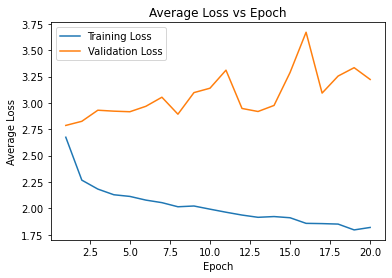

In [ ]:
x = np.asarray(list(range(1,21)))
plt.plot(x, train_loss_set, label = "Training Loss")
plt.plot(x, val_loss_set, label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch') 
plt.ylabel('Average Loss')  
plt.title('Average Loss vs Epoch') 
plt.show()

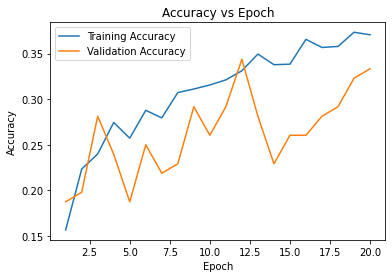

In [ ]:
x = np.asarray(list(range(1,21)))
plt.plot(x, train_acc_set, label = "Training Accuracy")
plt.plot(x, val_acc_set, label = "Validation Accuracy")
plt.legend()
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')  
plt.title('Accuracy vs Epoch') 
plt.show()